In [13]:
%reload_ext autoreload
%autoreload 2

from u_cmab import Fourier
from u_cmab import Static_UM
from u_cmab import plot_results
from u_cmab import LinUCB, offlineEvaluate
import simulation_code

import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

In [93]:
window = 150

static_dataset_size = 3500
total_experiment_count = 25000
drift_moments = np.array([7000,14000])

run_count = 10 #** 2

def map_context(con, arm, f):
    return f.basis(con, arm)

In [94]:
fourier_ids = np.empty([run_count, total_experiment_count])
fourier_reg_ids = np.empty([run_count, total_experiment_count])
linucb_ids = np.empty([run_count, total_experiment_count])
linucb_reg_ids = np.empty([run_count, total_experiment_count])
static_ids = np.empty([run_count, total_experiment_count])
static_params = np.empty([run_count, 2])

for i in range(run_count):
    tau= (.45 - .25) * np.random.ranf() + .25
    ply_q = np.random.randint(6,10)
    K=np.random.normal(1,.5, ply_q+1)
    drift_rate=1.3#2.5# (3.0 - 2.0) * np.random.ranf() + 2.0
    
        #  the order of the Fourier approx. (O) is best chosen in 
        #  function of D as O and D affect the amount of frequency 
        #  vectors exponentially, causing a curse of dimensionality
        #  [Konindaris et al., 2011].
    D = 2#np.random.randint(2,5)   
    O = 8-D 

    sim = simulation_code.Simulation(
        D=2, drift_moments=drift_moments, drift_rate=drift_rate, sudden_drift=True,
        base_functions=np.array([
            simulation_code.Sine_Base(f=4),#np.random.randint(6,10)), 
            simulation_code.Sine_Base(f=5)#np.random.randint(6,10))
        ]))
        
    fourier = Fourier(sim, order=5)
    fourier_id, fourier_dm, fourier_reg_id, tot_rew, exec_ac, tot_rew_reg, exec_ac_reg = fourier.run(
        epsilon=.1, 
        alpha=.005, 
        tau=tau, window=window, 
        lifetime=total_experiment_count)
    print("--e-greedy {} Completed--".format(i+1))
    
    Data = fourier.RP_run_history.values
    
    cntxt_0 = np.array([map_context(c, 0, fourier) for c in Data[:,:D]])
    cntxt_1 = np.array([map_context(c, 1, fourier) for c in Data[:,:D]])

    contexts = np.append(cntxt_0, cntxt_1, axis=1)
    
    print("--contexts {} Created--".format(i+1))
    
    linucb = LinUCB(2, len(cntxt_0[0]), 1.0)
    results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(
        linucb, 
        np.array([Data[:,-2], Data[:,-3]]).T, 
        contexts, tau, nrounds=total_experiment_count, u_cmab=1)
    
    linucb_diff = np.array([])
    linucb_id = np.array([])

    for j in range(len(chosen_arms_LinUCB)):
        linucb_diff = np.append(linucb_diff, abs(chosen_arms_LinUCB[j] - Data[:,-1][j]))
        linucb_id = np.append(linucb_id, np.average(linucb_diff[-window:]))
    print("--LinUCB U-CMAB {} Completed--".format(i+1))
    
    linucb_reg = LinUCB(2, len(cntxt_0[0]), 1.0)
    results_LinUCB_reg, chosen_arms_LinUCB_reg, cumulative_reward_LinUCB_reg = offlineEvaluate(
        linucb_reg, 
        np.array([Data[:,-2], Data[:,-3]]).T, 
        contexts, tau, nrounds=total_experiment_count, u_cmab=0)
    
    linucb_reg_diff = np.array([])
    linucb_reg_id = np.array([])

    for j in range(len(chosen_arms_LinUCB_reg)):
        linucb_reg_diff = np.append(linucb_reg_diff, abs(chosen_arms_LinUCB_reg[j] - Data[:,-1][j]))
        linucb_reg_id = np.append(linucb_reg_id, np.average(linucb_reg_diff[-window:]))
    print("--LinUCB CMAB {} Completed--".format(i+1))
    
    static = Static_UM(RP_run_history=fourier.RP_run_history)
    up, static_id = static.run( 
        static_dataset_size=static_dataset_size, 
        total_experiment_count=total_experiment_count, 
        tau=tau, window=window)

    
    fourier_ids[i] = fourier_id
    fourier_reg_ids[i] = fourier_reg_id
    static_ids[i] = static_id
    linucb_ids[i] = linucb_id
    linucb_reg_ids[i] = linucb_reg_id
    static_params[i] = list(up.rand_search_.best_params_.values())

--e-greedy 1 Completed--
--contexts 1 Created--
--LinUCB U-CMAB 1 Completed--
--LinUCB CMAB 1 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.0s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14126
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    5.3s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5874 AND len(decisions_after_r...) = 5874
25001
--e-greedy 2 Completed--
--contexts 2 Created--
--LinUCB U-CMAB 2 Completed--
--LinUCB CMAB 2 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.2s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14146
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.2s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5854 AND len(decisions_after_r...) = 5854
25001
--e-greedy 3 Completed--
--contexts 3 Created--
--LinUCB U-CMAB 3 Completed--
--LinUCB CMAB 3 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14201
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    5.3s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5799 AND len(decisions_after_r...) = 5799
25001
--e-greedy 4 Completed--
--contexts 4 Created--
--LinUCB U-CMAB 4 Completed--
--LinUCB CMAB 4 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.6s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14129
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    5.3s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5871 AND len(decisions_after_r...) = 5871
25001
--e-greedy 5 Completed--
--contexts 5 Created--
--LinUCB U-CMAB 5 Completed--
--LinUCB CMAB 5 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.3s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14149
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    5.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5851 AND len(decisions_after_r...) = 5851
25001
--e-greedy 6 Completed--
--contexts 6 Created--
--LinUCB U-CMAB 6 Completed--
--LinUCB CMAB 6 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.6s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14210


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.7s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5790 AND len(decisions_after_r...) = 5790
25001
--e-greedy 7 Completed--
--contexts 7 Created--
--LinUCB U-CMAB 7 Completed--
--LinUCB CMAB 7 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14178
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5822 AND len(decisions_after_r...) = 5822
25001
--e-greedy 8 Completed--
--contexts 8 Created--
--LinUCB U-CMAB 8 Completed--
--LinUCB CMAB 8 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.8s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14147
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.2s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5853 AND len(decisions_after_r...) = 5853
25001
--e-greedy 9 Completed--
--contexts 9 Created--
--LinUCB U-CMAB 9 Completed--
--LinUCB CMAB 9 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.8s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14185
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5815 AND len(decisions_after_r...) = 5815
25001
--e-greedy 10 Completed--
--contexts 10 Created--
--LinUCB U-CMAB 10 Completed--
--LinUCB CMAB 10 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.8s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 20000 AND len(decisions_after_r...) = 20000
14155
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.2s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5845 AND len(decisions_after_r...) = 5845
25001


In [95]:
line_args=[
    {"color": "firebrick", "linewidth": 2, "zorder": 102, "label": "Random Forest (ADWIN)"},
    {"color": "dodgerblue", "linewidth": 2, "zorder": 103, "label": "U-CMAB (e-greedy)"},      
    {"color": "forestgreen", "linewidth": 2, "zorder": 103, "label": "CMAB (e-greedy)"},
    {"color": "black", "linewidth": 2, "zorder": 103, "label": "U-CMAB (LinUCB)"}, 
    {"color": "orange", "linewidth": 2, "zorder": 103, "label": "CMAB (LinUCB)"}]
band_args=[
    {"color": "deeppink", "alpha": .15, "linewidth":0, "zorder": 100},
    {"color": "turquoise", "alpha": .35, "linewidth":0, "zorder": 101},  
    {"color": "lime", "alpha": .25, "linewidth":0, "zorder": 100}, 
    {"color": "gray", "alpha": .25, "linewidth":0, "zorder": 100}, 
    {"color": "orange", "alpha": .25, "linewidth":0, "zorder": 100}]
all_lines_args=[
    {"color": "crimson", "alpha": .1, "linewidth": .5},
    {"color": "deepskyblue", "alpha": .1, "linewidth": .5},  
    {"color": "black", "alpha": .1, "linewidth": .5}]
std_args=[
    {"color": "crimson", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},
    {"color": "deepskyblue", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},      
    {"color": "black", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},
    {"color": "gray", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]},
    {"color": "orange", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]}]

stop_RP_args={"color": "tab:gray", "linewidth":2, "linestyle": "--", "dashes": [5,5], "alpha": .8}
stop_RP_text_args={"y": .95, "color": "tab:gray", "size": 19, "fontstyle": "italic"}
drift_line_args={"linestyle": ":", "color": "tab:green", "alpha": 1, "linewidth": 3}

In [96]:
avg_ids = [np.mean(static_ids, axis=0), np.mean(fourier_ids, axis=0), np.mean(fourier_reg_ids, axis=0), np.mean(linucb_ids, axis=0), np.mean(linucb_reg_ids, axis=0)]
stds = [np.std(static_ids, axis=0), np.std(fourier_ids, axis=0), np.std(fourier_reg_ids, axis=0), np.std(linucb_ids, axis=0), np.std(linucb_reg_ids, axis=0)]

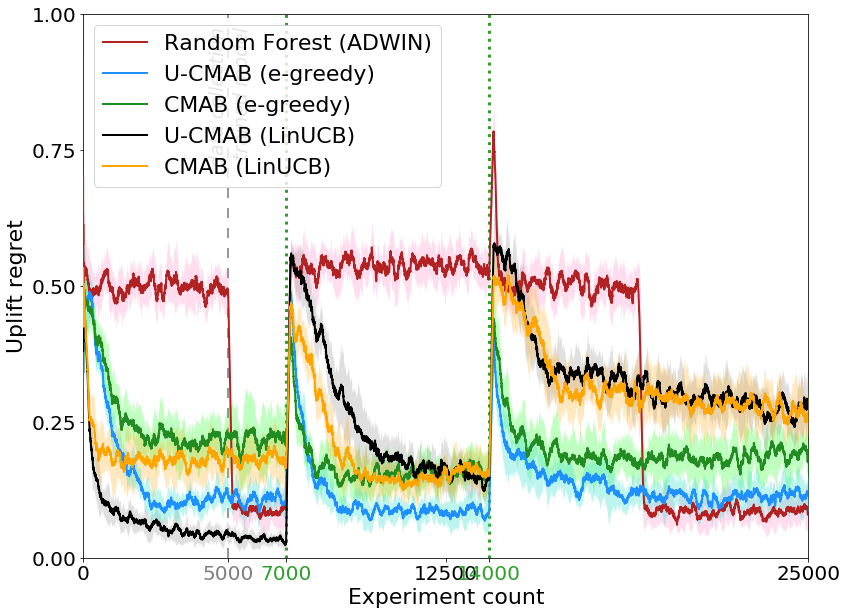

In [97]:
fig, ax = plot_results(avg_ids, stds, drift_moments, 
                 line_args=line_args, band_args=band_args, all_lines_args=all_lines_args, std_args=std_args,
                stop_RP=static_dataset_size, stop_RP_args=stop_RP_args, stop_RP_text_args=stop_RP_text_args, drift_line_args=drift_line_args)

In [98]:
ax.figure.savefig('sudden_drift_4.pdf', bbox_inches='tight', pad_inches=0)


In [122]:
static_dataset_size_gd = 2500
total_experiment_count_gd = 15000
drift_over_time_gd = 30000
run_count_gd = 10 #** 2


In [127]:
fourier_ids_gd = np.empty([run_count_gd, total_experiment_count_gd])
fourier_reg_ids_gd = np.empty([run_count_gd, total_experiment_count_gd])
linucb_ids_gd = np.empty([run_count_gd, total_experiment_count_gd])
linucb_reg_ids_gd = np.empty([run_count_gd, total_experiment_count_gd])
static_ids_gd = np.empty([run_count_gd, total_experiment_count_gd])
static_params_gd = np.empty([run_count_gd, 2])

for i in range(run_count_gd):
    tau= (.45 - .25) * np.random.ranf() + .25
    ply_q = np.random.randint(6,10)
    K=np.random.normal(1,.5, ply_q+1)
    drift_rate=(1.9 - 1.5) * np.random.ranf() + 1.5
    
        #  the order of the Fourier approx. (O) is best chosen in 
        #  function of D as O and D affect the amount of frequency 
        #  vectors exponentially, causing a curse of dimensionality
        #  [Konindaris et al., 2011].
    D = np.random.randint(2,4)   
    O = 7-D 

    sim = simulation_code.Simulation(
        D=D, drift_over_time=drift_over_time_gd, drift_rate=drift_rate, sudden_drift=False,
        base_functions=np.array([
            simulation_code.Sine_Base(f=np.random.randint(3,6)), 
            simulation_code.Sine_Base(f=np.random.randint(4,7))
        ]))
    
    fourier = Fourier(sim, order=O, regular=False)
    fourier_id, fourier_dm, fourier_reg_id, tot_rew, exec_ac, tot_rew_reg, exec_ac_reg = fourier.run(
        epsilon=.1, 
        alpha= (O-1)/1000,
        tau=tau, window=window, 
        lifetime=total_experiment_count_gd)
    print(f"--Fourier {i+1} Completed--")
    
    Data = fourier.RP_run_history.values
    
    cntxt_0 = np.array([map_context(c, 0, fourier) for c in Data[:,:D]])
    cntxt_1 = np.array([map_context(c, 1, fourier) for c in Data[:,:D]])

    contexts = np.append(cntxt_0, cntxt_1, axis=1)
    
    linucb = LinUCB(2, len(cntxt_0[0]), 1.0)
    results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(
        linucb, 
        np.array([Data[:,-2], Data[:,-3]]).T, 
        contexts, tau, nrounds=total_experiment_count_gd, u_cmab=1)
    
    linucb_diff = np.array([])
    linucb_id = np.array([])

    for j in range(len(chosen_arms_LinUCB)):
        linucb_diff = np.append(linucb_diff, abs(chosen_arms_LinUCB[j] - Data[:,-1][j]))
        linucb_id = np.append(linucb_id, np.average(linucb_diff[-window:]))
    print("--LinUCB U-CMAB {} Completed--".format(i+1))
    
    linucb_reg = LinUCB(2, len(cntxt_0[0]), 1.0)
    results_LinUCB_reg, chosen_arms_LinUCB_reg, cumulative_reward_LinUCB_reg = offlineEvaluate(
        linucb_reg, 
        np.array([Data[:,-2], Data[:,-3]]).T, 
        contexts, tau, nrounds=total_experiment_count_gd, u_cmab=0)
    
    linucb_diff_reg = np.array([])
    linucb_id_reg = np.array([])

    for j in range(len(chosen_arms_LinUCB_reg)):
        linucb_diff_reg = np.append(linucb_diff_reg, abs(chosen_arms_LinUCB_reg[j] - Data[:,-1][j]))
        linucb_id_reg = np.append(linucb_id_reg, np.average(linucb_diff_reg[-window:]))
    print("--LinUCB CMAB {} Completed--".format(i+1))
    
    static = Static_UM(RP_run_history=fourier.RP_run_history)
    up, static_id = static.run(PH_alpha=.05,
        static_dataset_size=static_dataset_size_gd, 
        total_experiment_count=total_experiment_count_gd, 
        tau=tau, window=window)
    
    fourier_ids_gd[i] = fourier_id
    fourier_reg_ids_gd[i] = fourier_reg_id
    linucb_ids_gd[i] = linucb_id
    linucb_reg_ids_gd[i] = linucb_id_reg
    static_ids_gd[i] = static_id
    static_params_gd[i] = list(up.rand_search_.best_params_.values())

--Fourier 1 Completed--
--LinUCB U-CMAB 1 Completed--
--LinUCB CMAB 1 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   19.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
6343
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.2s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 6157 AND len(decisions_after_r...) = 6157
14217
--Fourier 2 Completed--
--LinUCB U-CMAB 2 Completed--
--LinUCB CMAB 2 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
6587
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    4.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5913 AND len(decisions_after_r...) = 5913
14491
--Fourier 3 Completed--
--LinUCB U-CMAB 3 Completed--
--LinUCB CMAB 3 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    4.5s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
15001
--Fourier 4 Completed--
--LinUCB U-CMAB 4 Completed--
--LinUCB CMAB 4 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    4.3s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
15001
--Fourier 5 Completed--
--LinUCB U-CMAB 5 Completed--
--LinUCB CMAB 5 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    3.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
15001
--Fourier 6 Completed--
--LinUCB U-CMAB 6 Completed--
--LinUCB CMAB 6 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  80 out of 150 | elapsed:    2.3s remaining:    2.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    3.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
5321
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    3.8s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 7179 AND len(decisions_after_r...) = 7179
9970
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  80 out of 150 | elapsed:    2.2s remaining:    1.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    3.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 2530 AND len(decisions_after_r...) = 2530
15001
--Fourier 7 Completed--
--LinUCB U-CMAB 7 Completed--
--LinUCB CMAB 7 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    4.0s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
15001
--Fourier 8 Completed--
--LinUCB U-CMAB 8 Completed--
--LinUCB CMAB 8 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    3.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
9080
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  80 out of 150 | elapsed:    1.9s remaining:    1.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 3420 AND len(decisions_after_r...) = 3420
15001
--Fourier 9 Completed--
--LinUCB U-CMAB 9 Completed--
--LinUCB CMAB 9 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    4.3s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
7363
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    3.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 5137 AND len(decisions_after_r...) = 5137
14512
--Fourier 10 Completed--
--LinUCB U-CMAB 10 Completed--
--LinUCB CMAB 10 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    4.0s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 12500 AND len(decisions_after_r...) = 12500
6245
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  80 out of 150 | elapsed:    2.1s remaining:    1.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    3.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 6255 AND len(decisions_after_r...) = 6255
12029
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  80 out of 150 | elapsed:    1.8s remaining:    1.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.7s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


len(action_results) = 471 AND len(decisions_after_r...) = 471
15001


In [128]:
avg_ids_gd = [np.mean(static_ids_gd, axis=0),np.mean(fourier_ids_gd, axis=0),  np.mean(fourier_reg_ids_gd, axis=0), np.mean(linucb_ids_gd, axis=0), np.mean(linucb_reg_ids_gd, axis=0)]
stds_gd = [np.std(static_ids_gd, axis=0), np.std(fourier_ids_gd, axis=0), np.std(fourier_reg_ids_gd, axis=0), np.std(linucb_ids_gd, axis=0), np.std(linucb_reg_ids_gd, axis=0)]

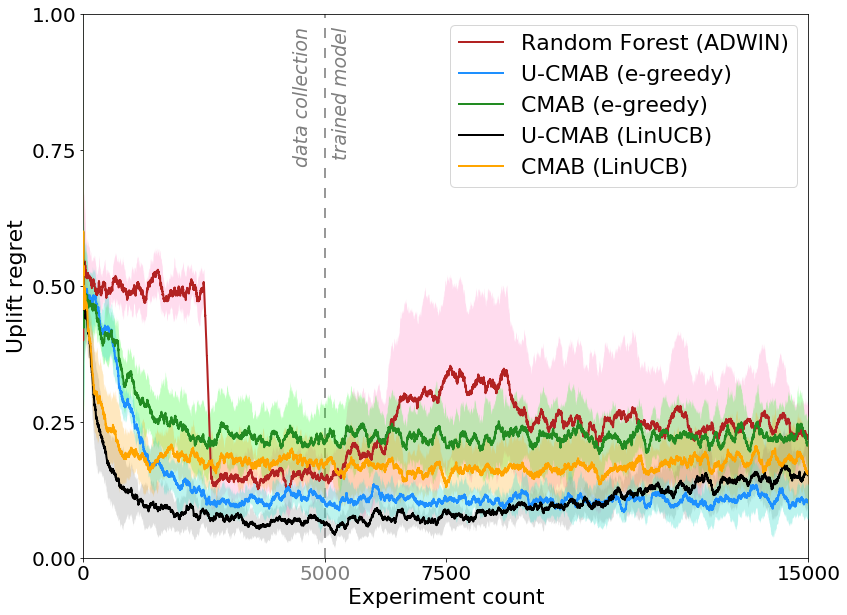

In [129]:
fig_gd, ax_gd = plot_results(avg_ids_gd, stds_gd, np.array([]), 
                 line_args=line_args, band_args=band_args, all_lines_args=all_lines_args, std_args=std_args,
                stop_RP=static_dataset_size, stop_RP_args=stop_RP_args, stop_RP_text_args=stop_RP_text_args, drift_line_args=drift_line_args)

In [130]:
ax_gd.figure.savefig('gradual_drift_05.pdf', bbox_inches='tight', pad_inches=0)
